In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from os.path import join

In [2]:
ABCD_DIR = "/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release5.1/abcd-data-release-5.1/core"

PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/kangaroo_aim1/"
DATA_DIR = "data/"
OUTP_DIR = "output/"

In [3]:
inc = pd.read_csv(
    join(ABCD_DIR, 'imaging', 'mri_y_qc_incl.csv'), 
    index_col=[0,1], 
    usecols=[
        'src_subject_id', 
        'eventname',
        'imgincl_t1w_include', 
        'imgincl_t2w_include', 
        'imgincl_dmri_include',
        'imgincl_rsfmri_include'
    ]
)
mot = pd.read_csv(
    join(ABCD_DIR, 'imaging', 'mri_y_qc_motion.csv'), 
    index_col=[0,1], 
    usecols=[
        'src_subject_id', 
        'eventname',
        'dmri_meanmotion', 
        'rsfmri_meanmotion', 
        'rsfmri_subthreshnvols',
        'rsfmri_ntpoints'
    ]
)
cln = pd.read_csv(join(ABCD_DIR, 'imaging', 'mri_y_qc_clfind.csv'), 
                  index_col=[0,1], 
                  low_memory=False,
                  usecols=['src_subject_id', 'eventname','mrif_score'])

In [4]:
dem = pd.read_csv(
    '/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/ABCD_Covariates/ABCD_release5.0/01_Demographics/ABCD_5.0_demographics_concise_final.csv', 
    index_col=[1,2], low_memory=False)

In [5]:
dem.head()

Unnamed: 0  interview_age  \
src_subject_id   eventname                                             
NDAR_INV003RTV85 baseline_year_1_arm_1              1          131.0   
                 6_month_follow_up_arm_1            2          136.0   
                 1_year_follow_up_y_arm_1           3          143.0   
                 18_month_follow_up_arm_1           4          148.0   
                 2_year_follow_up_y_arm_1           5          157.0   

                                           rel_family_id_bl site_id_l  \
src_subject_id   eventname                                              
NDAR_INV003RTV85 baseline_year_1_arm_1                 8781    site06   
                 6_month_follow_up_arm_1               8781    site06   
                 1_year_follow_up_y_arm_1              8781    site06   
                 18_month_follow_up_arm_1              8781    site06   
                 2_year_follow_up_y_arm_1              8781    site06   

                                          site_names race_ethnicity_bl  \
src_subject_id   eventname                                               
NDAR_INV003RTV85 baseline_year_1_arm_1          OHSU             White   
                 6_month_follow_up_arm_1        OHSU             White   
                 1_year_follow_up_y_arm_1       OHSU             White   
                 18_month_follow_up_arm_1       OHSU             White   
                 2_year_follow_up_y_arm_1       OHSU             White   

                                          race_ethnicity_c_bl  \
src_subject_id   eventname                                      
NDAR_INV003RTV85 baseline_year_1_arm_1                  White   
                 6_month_follow_up_arm_1                White   
                 1_year_follow_up_y_arm_1               White   
                 18_month_follow_up_arm_1               White   
                 2_year_follow_up_y_arm_1               White   

                                          race_ethnicity_detail_bl  \
src_subject_id   eventname                                           
NDAR_INV003RTV85 baseline_year_1_arm_1          Non-Hispanic White   
                 6_month_follow_up_arm_1        Non-Hispanic White   
                 1_year_follow_up_y_arm_1       Non-Hispanic White   
                 18_month_follow_up_arm_1       Non-Hispanic White   
                 2_year_follow_up_y_arm_1       Non-Hispanic White   

                                          demo_sex_v2_bl  \
src_subject_id   eventname                                 
NDAR_INV003RTV85 baseline_year_1_arm_1            Female   
                 6_month_follow_up_arm_1          Female   
                 1_year_follow_up_y_arm_1         Female   
                 18_month_follow_up_arm_1         Female   
                 2_year_follow_up_y_arm_1         Female   

                                          household_income_4bins_bl  \
src_subject_id   eventname                                            
NDAR_INV003RTV85 baseline_year_1_arm_1             [≥50K and <100K]   
                 6_month_follow_up_arm_1           [≥50K and <100K]   
                 1_year_follow_up_y_arm_1          [≥50K and <100K]   
                 18_month_follow_up_arm_1          [≥50K and <100K]   
                 2_year_follow_up_y_arm_1          [≥50K and <100K]   

                                          household_income_4bins_tp  \
src_subject_id   eventname                                            
NDAR_INV003RTV85 baseline_year_1_arm_1             [≥50K and <100K]   
                 6_month_follow_up_arm_1                        NaN   
                 1_year_follow_up_y_arm_1          [≥50K and <100K]   
                 18_month_follow_up_arm_1                       NaN   
                 2_year_follow_up_y_arm_1          [≥50K and <100K]   

                                          highest_parent_educ_bl  \
src_subject_id   eventname                                         
NDAR_IN

In [14]:
raceth = dem['race_ethnicity_bl'].dropna().unique()
eductn = dem['highest_parent_educ_bl'].unique()

In [15]:
list(eductn)

['HS Diploma/GED',
 '< HS Diploma',
 'Post Graduate Degree',
 'Some College',
 'Bachelor Degree',
 'Missing/Refused']

In [16]:
# new approach: create indices for levels of all demo vars & 
# indices for "good" images, and then use the len(set() & set())
# to calculate counts

In [17]:
events = [
    'baseline_year_1_arm_1',
    '2_year_follow_up_y_arm_1',
    '4_year_follow_up_y_arm_1'
]

In [18]:

good_counts = pd.DataFrame(
    dtype=int,
    columns=pd.MultiIndex.from_product([events, ['T1w', 'T2w', 'dMRI', 'rsfMRI']]),
    index=['all'] + list(raceth) + list(eductn)
)

for event in events:
    temp_img = inc.swaplevel(0).loc[event]
    temp_dem = dem.swaplevel(0).loc[event]
    temp_mot = mot.swaplevel(0).loc[event]
    temp_cln = cln.swaplevel(0).loc[event]
    findings = temp_cln[temp_cln['mrif_score'].between(1,2, inclusive='both')].index
    temp_t1 = temp_img[temp_img['imgincl_t1w_include'] == 1].index
    temp_t2 = temp_img[temp_img['imgincl_t2w_include'] == 1].index
    temp_dwi = temp_img[temp_img['imgincl_dmri_include'] == 1].index
    dwi_mot = temp_mot[temp_mot['dmri_meanmotion'] < 2.].index
    temp_rsf = temp_img[temp_img['imgincl_rsfmri_include'] == 1].index
    rsf_mot = temp_mot[temp_mot['rsfmri_ntpoints'] >= 750.].index
    rsf_mot2 = temp_mot[temp_mot['rsfmri_meanmotion'] < 0.5].index
    good_counts.at['all', ((event, 'T1w'))] = len(set(temp_t1) & set(findings))
    good_counts.at['all', ((event, 'T2w'))] = len(set(temp_t2) & set(findings))
    good_counts.at['all', ((event, 'dMRI'))] = len(set(temp_dwi) & set(dwi_mot) & set(findings))
    good_counts.at['all', ((event, 'rsfMRI'))] = len(set(temp_rsf) & set(rsf_mot) & set(rsf_mot2) & set(findings))
    for level in raceth:
        temp = temp_dem[temp_dem['race_ethnicity_bl'] == level].index
        good_counts.at[level, ((event, 'T1w'))] = len(set(temp) & set(temp_t1) & set(findings))
        good_counts.at[level, ((event, 'T2w'))] = len(set(temp) & set(temp_t2) & set(findings))
        good_counts.at[level, ((event, 'dMRI'))] = len(set(temp) & set(temp_dwi) & set(dwi_mot) & set(findings))
        good_counts.at[level, ((event, 'rsfMRI'))] = len(set(temp) & set(temp_rsf) & set(rsf_mot) & set(rsf_mot2) & set(findings))
    for level in eductn:
        temp = temp_dem[temp_dem['highest_parent_educ_bl'] == level].index
        #good_counts.at[level, ((event, 'T1w'))] = len(temp2)
        good_counts.at[level, ((event, 'T1w'))] = len(set(temp) & set(temp_t1) & set(findings))
        good_counts.at[level, ((event, 'T2w'))] = len(set(temp) & set(temp_t2) & set(findings))
        good_counts.at[level, ((event, 'dMRI'))] = len(set(temp) & set(temp_dwi) & set(dwi_mot) & set(findings))
        good_counts.at[level, ((event, 'rsfMRI'))] = len(set(temp) & set(temp_rsf) & set(rsf_mot) & set(rsf_mot2) & set(findings))


In [20]:
good_counts.to_csv(join(PROJ_DIR, 'quality_mri_data-counts.csv'))

In [21]:
good_counts

baseline_year_1_arm_1                           \
                                       T1w      T2w    dMRI  rsfMRI   
all                                10787.0  10137.0  9279.0  6856.0   
White                               5629.0   5351.0  4984.0  3819.0   
Hispanic                            2214.0   2084.0  1883.0  1333.0   
Black                               1580.0   1429.0  1279.0   847.0   
Other                               1139.0   1058.0   957.0   725.0   
Asian                                223.0    213.0   174.0   130.0   
HS Diploma/GED                      1022.0    915.0   812.0   538.0   
< HS Diploma                         534.0    486.0   427.0   275.0   
Post Graduate Degree                3685.0   3530.0  3273.0  2514.0   
Some College                        2799.0   2606.0  2357.0  1689.0   
Bachelor Degree                     2735.0   2588.0  2399.0  1837.0   
Missing/Refused                       12.0     12.0    11.0     3.0   

                     2_year_follow_up_y_arm_1                          \
                                          T1w     T2w    dMRI  rsfMRI   
all                                    7511.0  7174.0  6897.0  5618.0   
White                                  4133.0  3969.0  3851.0  3228.0   
Hispanic                               1444.0  1390.0  1313.0  1078.0   
Black                                  1008.0   933.0   905.0   645.0   
Other                                   787.0   751.0   703.0   570.0   
Asian                                   139.0   131.0   125.0    97.0   
HS Diploma/GED                          634.0   599.0   562.0   424.0   
< HS Diploma                            339.0   317.0   289.0   223.0   
Post Graduate Degree                   2610.0  2519.0  2442.0  2062.0   
Some College                           1923.0  1829.0  1752.0  1393.0   
Bachelor Degree                        1993.0  1899.0  1842.0  1511.0   
Missing/Refused                          12.0    11.0    10.0     5.0   

                     4_year_follow_up_y_arm_1                          
                                          T1w     T2w    dMRI  rsfMRI  
all                                    2827.0  2772.0  2684.0  2474.0  
White                                  1606.0  1580.0  1531.0  1438.0  
Hispanic                                565.0   556.0   545.0   490.0  
Black                                   302.0   290.0   280.0   249.0  
Other                                   292.0   285.0   273.0   247.0  
Asian                                    62.0    61.0    55.0    50.0  
HS Diploma/GED                          199.0   195.0   190.0   175.0  
< HS Diploma                            120.0   116.0   112.0    97.0  
Post Graduate Degree                    996.0   983.0   944.0   902.0  
Some College                            736.0   724.0   703.0   633.0  
Bachelor Degree                         772.0   750.0   731.0   664.0  
Missing/Refused                           4.0     4.0     4.0     3.0

In [44]:
qc_df = pd.DataFrame(
    0,
    dtype=int,
    columns=good_counts.columns,
    index=inc.index.get_level_values(0).unique()
)

In [45]:
for event in events:
    temp_img = inc.swaplevel(0).loc[event]
    temp_dem = dem.swaplevel(0).loc[event]
    temp_mot = mot.swaplevel(0).loc[event]
    temp_cln = cln.swaplevel(0).loc[event]
    findings = temp_cln[temp_cln['mrif_score'].between(1,2, inclusive='both')].index
    temp_t1 = temp_img[temp_img['imgincl_t1w_include'] == 1].index
    temp_t2 = temp_img[temp_img['imgincl_t2w_include'] == 1].index
    temp_dwi = temp_img[temp_img['imgincl_dmri_include'] == 1].index
    dwi_mot = temp_mot[temp_mot['dmri_meanmotion'] < 2.].index
    temp_rsf = temp_img[temp_img['imgincl_rsfmri_include'] == 1].index
    rsf_mot = temp_mot[temp_mot['rsfmri_ntpoints'] >= 750.].index
    rsf_mot2 = temp_mot[temp_mot['rsfmri_meanmotion'] < 0.5].index
    good_t1 = list(set(temp_t1) & set(findings))
    good_t2 = list(set(temp_t2) & set(findings))
    good_dwi = list(set(temp_dwi) & set(dwi_mot) & set(findings))
    good_rsf = list(set(temp_rsf) & set(rsf_mot) & set(rsf_mot2) & set(findings))
    for i in qc_df.index:
        if i in good_t1:
            qc_df.at[i,(event, 'T1w')] = 1
        if i in good_t2:
            qc_df.at[i, (event, 'T2w')] = 1
        if i in good_dwi:
            qc_df.at[i, (event, 'dMRI')] = 1
        if i in good_rsf:
            qc_df.at[i, (event, 'rsfMRI')] = 1

In [46]:
qc_df

baseline_year_1_arm_1                  \
                                   T1w T2w dMRI rsfMRI   
src_subject_id                                           
NDAR_INV003RTV85                     1   1    1      1   
NDAR_INV005V6D2C                     1   1    1      0   
NDAR_INV007W6H7B                     1   1    0      1   
NDAR_INV00BD7VDC                     1   1    1      1   
NDAR_INV00CY2MDM                     1   1    1      0   
...                                ...  ..  ...    ...   
NDAR_INVZZNX6W2P                     1   1    1      1   
NDAR_INVZZPKBDAC                     1   1    1      1   
NDAR_INVZZZ2ALR6                     1   1    1      1   
NDAR_INVZZZNB0XC                     1   1    1      1   
NDAR_INVZZZP87KR                     1   1    0      0   

                 2_year_follow_up_y_arm_1                  \
                                      T1w T2w dMRI rsfMRI   
src_subject_id                                              
NDAR_INV003RTV85                        0   0    0      0   
NDAR_INV005V6D2C                        0   0    0      0   
NDAR_INV007W6H7B                        0   0    0      0   
NDAR_INV00BD7VDC                        0   0    0      0   
NDAR_INV00CY2MDM                        1   1    1      1   
...                                   ...  ..  ...    ...   
NDAR_INVZZNX6W2P                        1   1    1      1   
NDAR_INVZZPKBDAC                        1   1    1      1   
NDAR_INVZZZ2ALR6                        1   1    1      1   
NDAR_INVZZZNB0XC                        0   0    0      0   
NDAR_INVZZZP87KR                        1   1    1      0   

                 4_year_follow_up_y_arm_1                  
                                      T1w T2w dMRI rsfMRI  
src_subject_id                                             
NDAR_INV003RTV85                        0   0    0      0  
NDAR_INV005V6D2C                        0   0    0      0  
NDAR_INV007W6H7B                        0   0    0      0  
NDAR_INV00BD7VDC                        0   0    0      0  
NDAR_INV00CY2MDM                        1   1    1      1  
...                                   ...  ..  ...    ...  
NDAR_INVZZNX6W2P                        1   1    1      1  
NDAR_INVZZPKBDAC                        1   1    1      1  
NDAR_INVZZZ2ALR6                        0   0    0      0  
NDAR_INVZZZNB0XC                        1   1    1      1  
NDAR_INVZZZP87KR                        1   1    1      1  

[11820 rows x 12 columns]

In [48]:
time = pd.read_csv(
    join(ABCD_DIR, 'imaging', 'mri_y_qc_raw_smr_t1.csv'), 
    usecols=['src_subject_id', 'eventname', 'iqc_t1_1_seriestime'], 
)

<AxesSubplot:xlabel='iqc_t1_1_seriestime', ylabel='Count'>

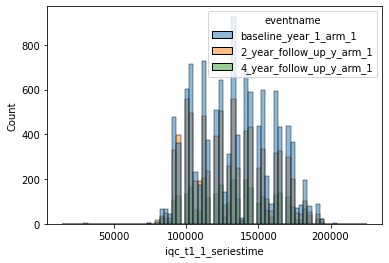

In [50]:
sns.histplot(time, x='iqc_t1_1_seriestime', hue='eventname')

In [51]:
time['iqc_t1_1_seriestime'].describe()

count     23019.000000
mean     132148.170424
std       26360.430997
min       14248.300000
25%      110852.000000
50%      131838.000000
75%      152631.500000
max      225002.000000
Name: iqc_t1_1_seriestime, dtype: float64

In [53]:
225002 / 60 / 60

62.50055555555556

In [56]:
temp = pd.read_csv('/Volumes/projects_herting/LABDOCS/PROJECTS/ABCD/Data/release4.0/csv/mriqcrp10301.csv')

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_35400/3014479769.py:1: DtypeWarning: Columns (0,1,2,6,12,13,14,15,16,17,18,19,23,24,25,26,27,28,29,30,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,65,66,67,68,69,70,71,72,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270

In [57]:
temp['iqc_t1_1_seriestime']

0        T1 #1: Series time
1                  115711.0
2                  100001.0
3                  133041.0
4                  121227.0
                ...        
19696              150803.0
19697              144129.0
19698              141340.0
19699              112018.0
19700              102704.0
Name: iqc_t1_1_seriestime, Length: 19701, dtype: object

32.14194444444444